# Finding the Band Gap 

## Equations
Densidad Óptica
\begin{equation}
O.D = \frac{\alpha l}{ln(10)}
\end{equation}
K (numero de onda) 
\begin{equation}
k = \frac{\alpha \lambda}{4\pi}
\end{equation}
Transmitancia y Reflectancia
\begin{align}
T = (1-R)^{2} e^{-\alpha l}\\
R =  1 -e^{\frac{1}{2}\alpha l}T^{\frac{1}{2}}
\end{align}


In [30]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

## Variables

Importación de datos

In [38]:
class material:
            
    def __init__(self, name,l,refraction_coefficient):
        data = pd.read_excel('datos_tecnicas.xlsx')
        c1 = 100000000
        c2 = 100000000000
        self.name = name
        self.l = l
        self.refraction_coefficient = refraction_coefficient
        self.wavelength = pd.to_numeric(data["Wavelength"], errors='coerce')
        transmitancia = pd.to_numeric(data[f'{self.name}_T']/c1, errors='coerce')
        absorbancia =  pd.to_numeric(data[f'{self.name}_Abs']/c2, errors='coerce') 
        while(transmitancia[transmitancia < 20].size > 0):
            transmitancia[transmitancia < 20] = transmitancia[transmitancia <20]*10
        while(absorbancia[absorbancia < 20].size > 0):
            absorbancia[absorbancia < 20] = absorbancia[absorbancia <20]*10
        self.transmitancia = transmitancia
        self.absorbancia =absorbancia   
       
        
    def R_theoric_calc(self):
        '''
        Calcula la transmitancia con  R = 1 - e**(0.5*self.absorbancia*l)*transmitancia[i]
        '''
        size = self.transmitancia.size
        R = np.empty(size, dtype=float)
        for i in range(size):
            R[i] = 1 - ( (np.e**(0.5*self.absorbancia[i]*self.l))*self.transmitancia[i])
        return R
    def k_calc(self):
        '''
        Calcula el numero de onda  como k = (alpha*lambda)/4pi
        devuelve un dataframe de pandas
        '''
        size = self.absorbancia.size
        k = np.empty(size, dtype=float)
        for i in range(size):
            k[i] = self.absorbancia[i]*self.wavelength[i]/4*np.pi#Numero de onda
        return k 
    def do_calc(self):
        '''
        Calcula la densidad optica  como  d.o = (absorbancia*self.l)/(np.log(10))#Espesor del material
        devuelve un dataframe de pandas
        '''
        size = self.absorbancia.size
        do = np.empty(size, dtype=float)
        for i in range(size):
            do[i] = (self.absorbancia[i]*self.l)/(np.log(10))#Espesor del material
        return do

    def graph_abs(self):
            '''
            Gráfica la  la longitud de onda vs  absorbancia
            '''
            plt.style.use('Solarize_Light2')
            plt.figure(figsize=(10,5))
            plt.scatter(self.wavelength,self.absorbancia,label=self.name, color='green')
            plt.xlabel("longitud de onda (nm)")
            plt.ylabel("Absorbancia")
            plt.title("Absorbancia del"+self.name)
            plt.legend()
            plt.show()

    def graph_T(self):
            '''
            Gráfica la  la longitud de onda vs la transmitancia 
            '''
            plt.style.use('Solarize_Light2')
            plt.figure(figsize=(10,5))
            plt.scatter(self.wavelength,self.transmitancia,label=self.name, color='blue')
            plt.xlabel("longitud de onda (nm)")
            plt.ylabel("Transmitancia")
            plt.title("Transmitancia del"+self.name)
            plt.legend()
            plt.show()    
    def graph_do(self):
            '''
            Gráfica la  la longitud de onda vs la transmitancia 
            '''
            plt.style.use('Solarize_Light2')
            plt.figure(figsize=(10,5))
            plt.scatter(self.wavelength,self.transmitancia,label=self.name, color='black')
            plt.xlabel("absorbancia")
            plt.ylabel("Densidad Optica")
            plt.title("Densidad optica del "+self.name)
            plt.legend()
            plt.show()
    def graph_R_Theoric(self,R):
            '''
            Gráfica la  la longitud de onda vs la transmitancia 
            '''
            plt.style.use('Solarize_Light2')
            plt.figure(figsize=(10,5))
            plt.scatter(self.wavelength,R,label=self.name, color='cyan')
            plt.xlabel("Wavelength")
            plt.ylabel("Reflectancia Teorica")
            plt.title("Reflectancia teorica de "+self.name)
            plt.legend()
            plt.show()
    def graph_do(self,k,do):
            '''
            Gráfica de la absorbancia vs densidad optica 
            '''
            plt.style.use('Solarize_Light2')
            plt.figure(figsize=(10,5))
            plt.scatter(k,do,label=self.name, color='red')
            plt.xlabel("absorbancia")
            plt.ylabel("densidad optica")
            plt.title("densidad optica del "+self.name)
            plt.legend()
            plt.show()
    def graph_k(self,k):  
            '''
            Gráfica la longitud de onda vs el numero de onda k
            '''
            plt.style.use('Solarize_Light2')
            plt.figure(figsize=(10,5))
            plt.scatter(self.wavelength,k,label=self.name, color='violet')
            plt.xlabel("numero de onda")
            plt.ylabel("K")
            plt.title("Numero de onda del "+self.name)
            plt.legend()
            plt.show()
       

    

In [39]:
vidrio =  material("Vidrio",0.98,1.5)
acetato = material("Acetato",0.1,1.3720)
cristal = material("Cristal",0.2,1.5)

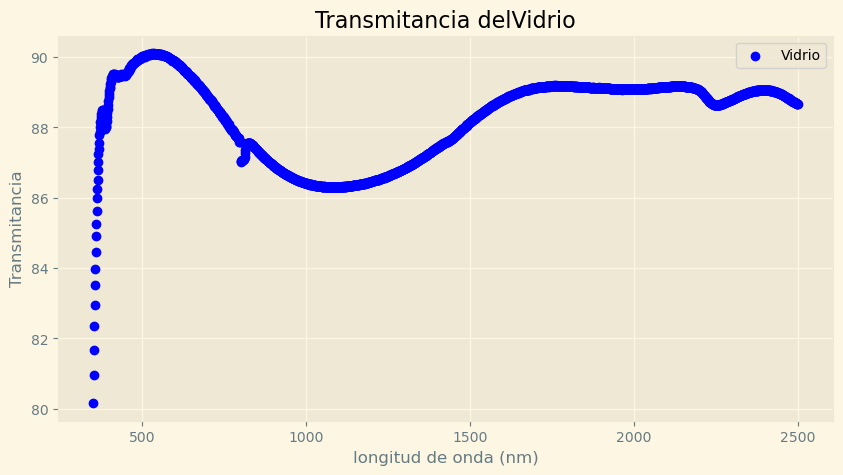

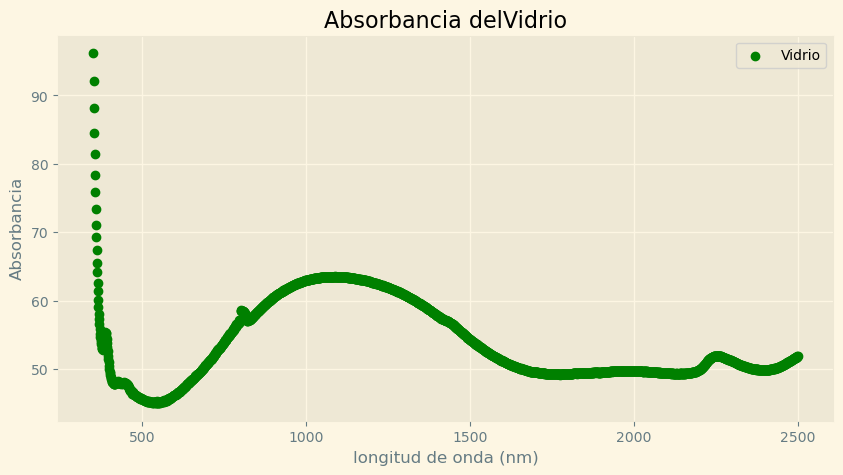

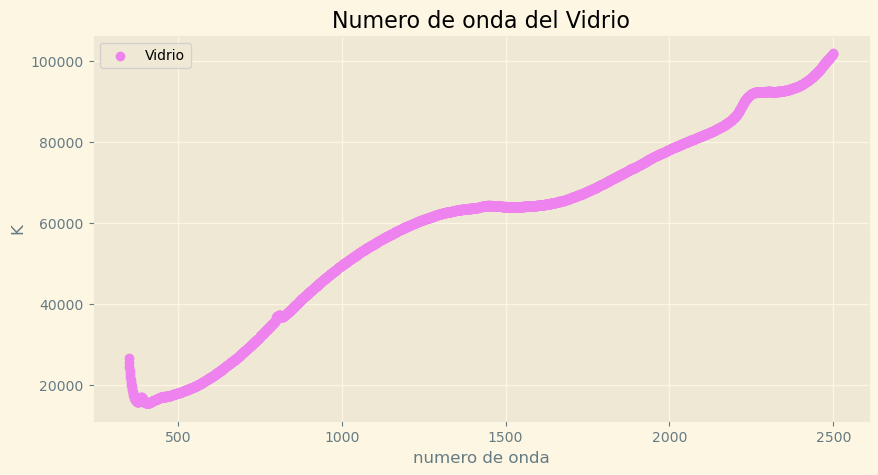

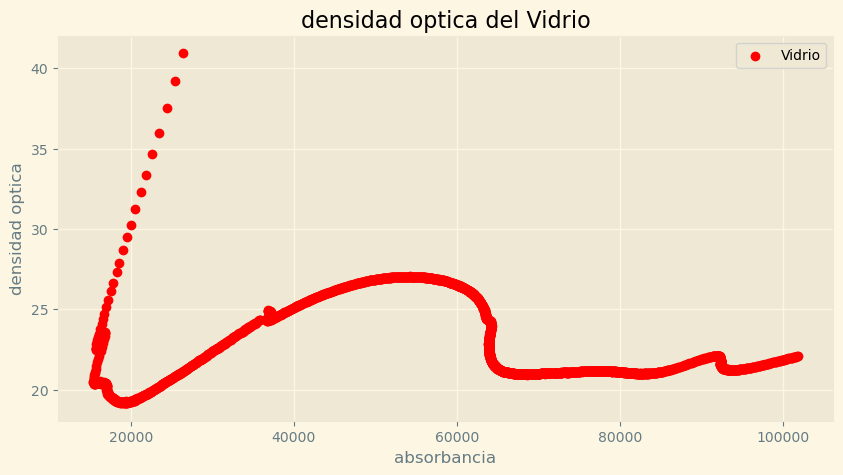

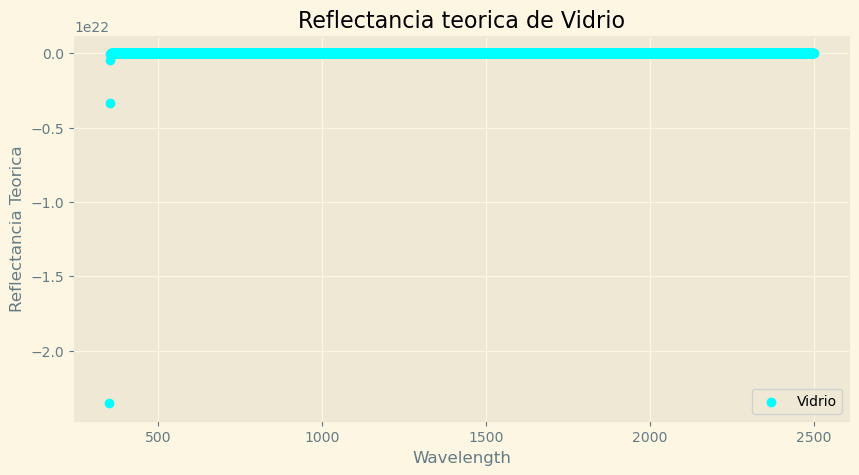

In [40]:
k_vidrio=vidrio.k_calc()
vidrio.graph_T()
vidrio.graph_abs()
vidrio.graph_k(k_vidrio)
vidrio.graph_do(k_vidrio,vidrio.do_calc())
vidrio.graph_R_Theoric(vidrio.R_theoric_calc())

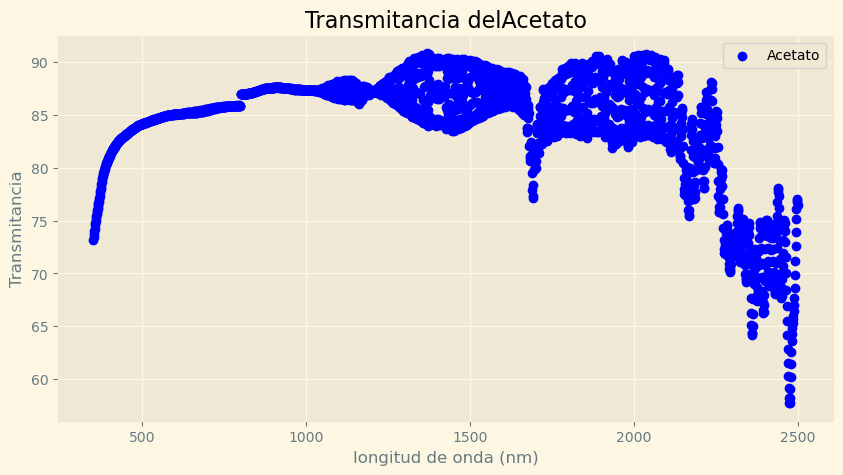

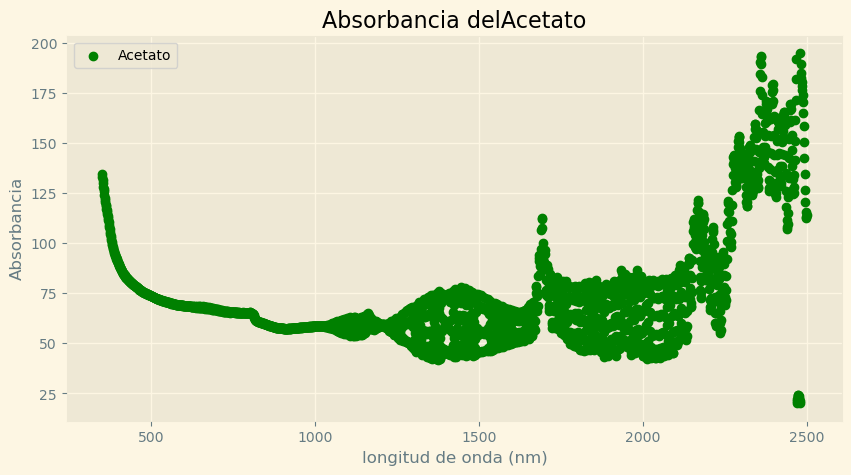

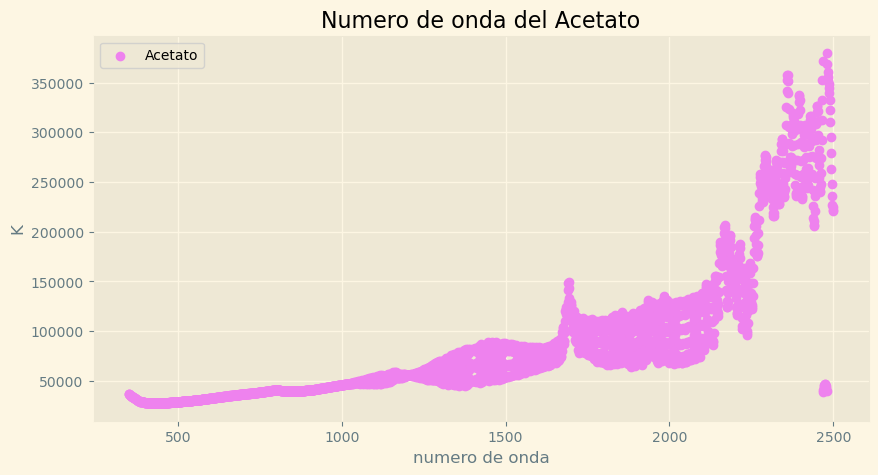

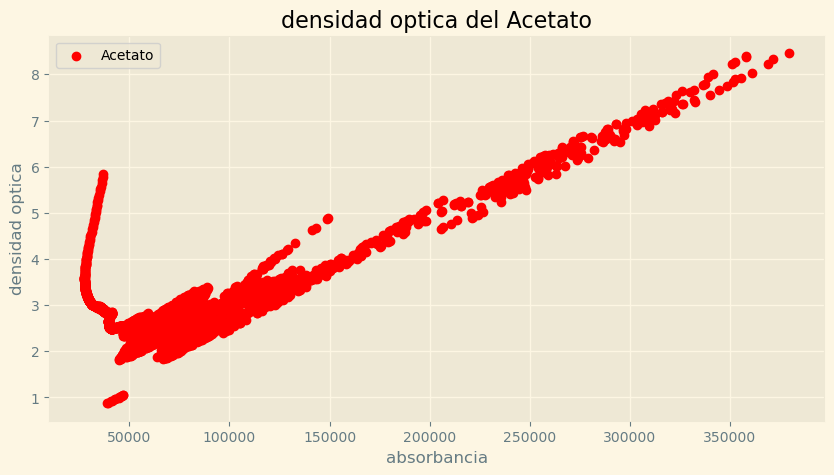

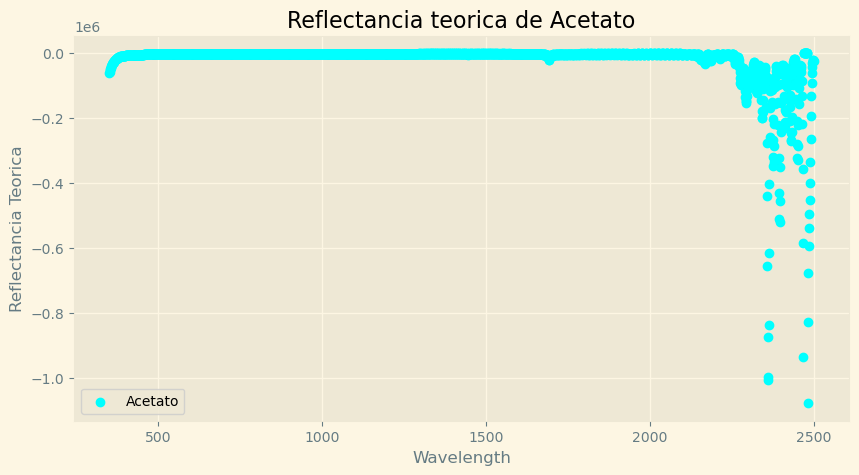

In [41]:
k_acetato=acetato.k_calc()
acetato.graph_T()
acetato.graph_abs()
acetato.graph_k(k_acetato)
acetato.graph_do(k_acetato,acetato.do_calc())
acetato.graph_R_Theoric(acetato.R_theoric_calc())

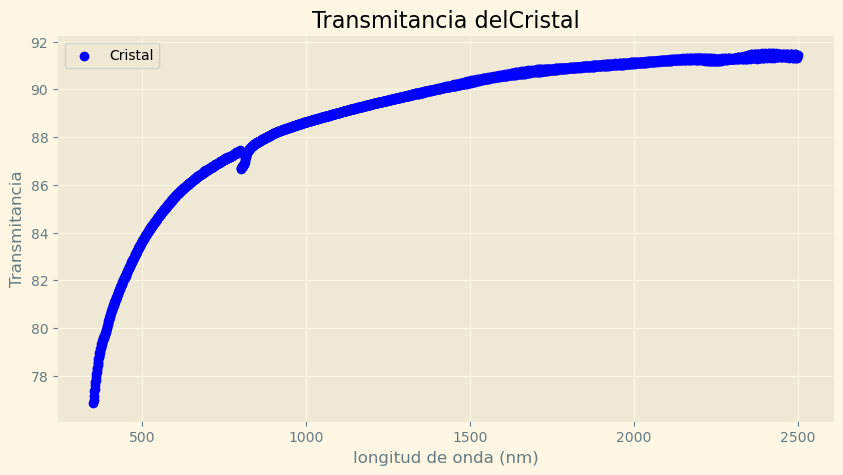

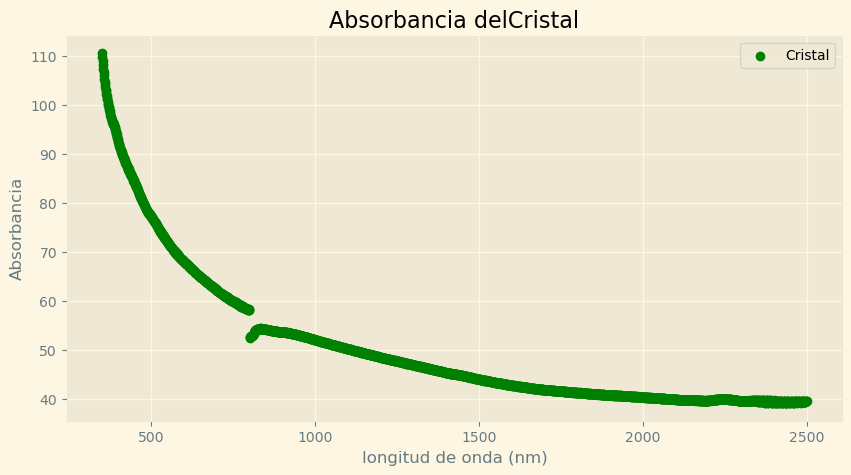

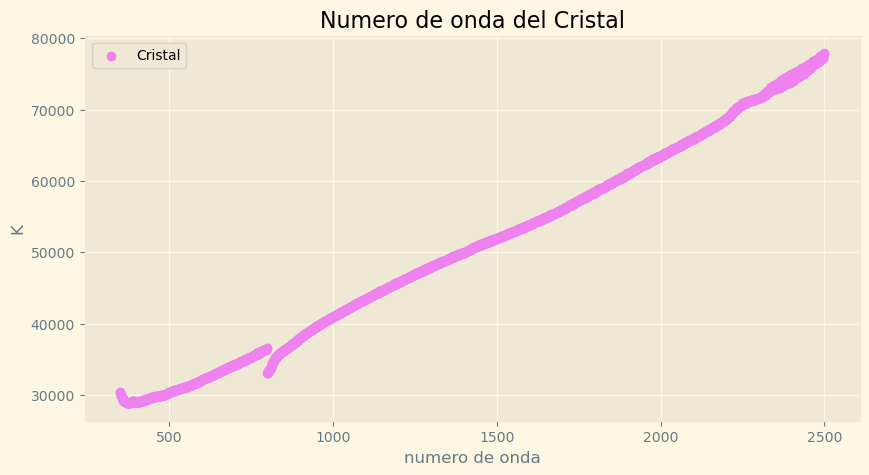

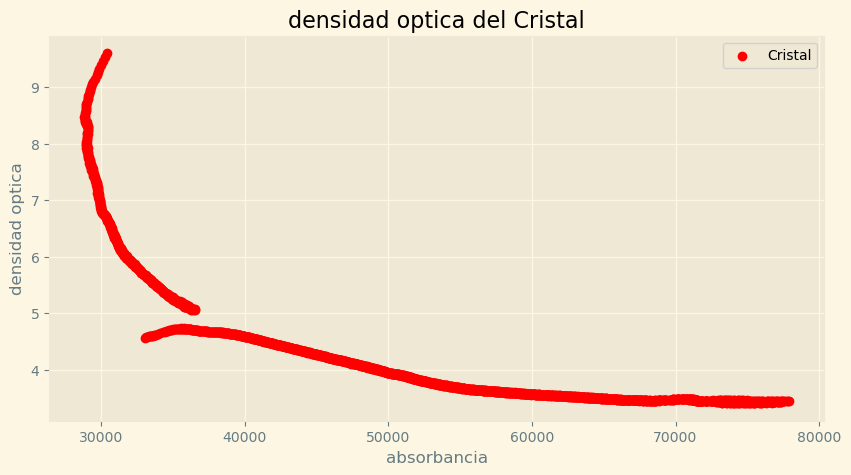

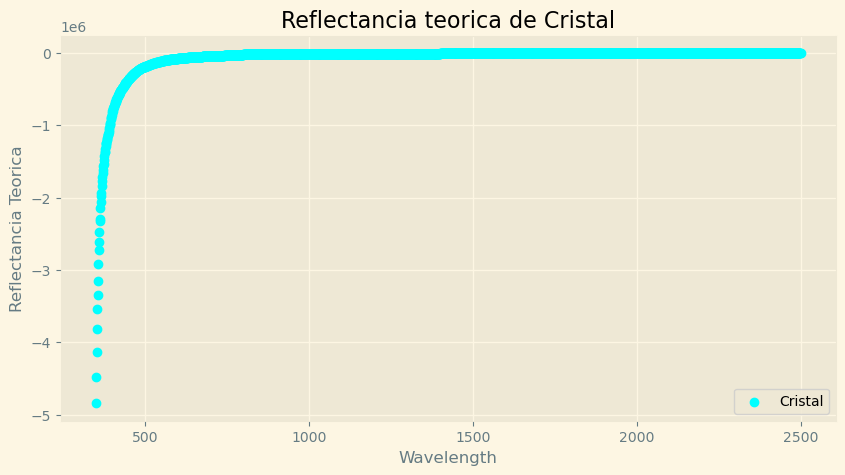

In [42]:
k_cristal=cristal.k_calc()
cristal.graph_T()
cristal.graph_abs()
cristal.graph_k(k_cristal)
cristal.graph_do(k_cristal,cristal.do_calc())
cristal.graph_R_Theoric(cristal.R_theoric_calc())